# WIKIDATA

## Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time
from tqdm import tqdm

## Functions

In [2]:
# Function to get request in a more efficient way without 1 to 1 corresponding request
def handle_get_request(entities_list,labeled):
        batch_size=40 # number of entity from extraction 
        url_base = "https://www.wikidata.org/w/api.php" # url base to peform a HTTP request to obtain Wikidata properties using api
        results = {} # dictionary  where entity |Qxxx| are the keys while the claims will be the corresponding values
        total_batches = (len(entities_list) + batch_size - 1) // batch_size # compute how many subsets of extraction 

        with tqdm(total=total_batches, desc=f"Downloading batch of class {labeled}") as pbar:
            for i in range(0, len(entities_list), batch_size): # loop for every batch of all entities

                batch = entities_list[i:i + batch_size] # i-th batch
                ids_string = "|".join(batch) # Considers a sequence of |Q1xxx|Q2xxx| items to collect from the server
                
                # define parameters of get request
                params = { 
                    "action": "wbgetentities", # obtain wbentities
                    "ids": ids_string, # specify which items we want to extract corresponding to the i-th batch
                    "format": "json"
                }

                attempt=0 # number of attempt in case of errors
                success=False

                while not success and attempt <3:

                    try:

                        response_get_id = requests.get(url_base, params=params, timeout=20) # it obtains a get of properties using previous parameters  
                        response_get_id.raise_for_status() # verify if the HTTP request fails and eventually store the error in e 
                        data = response_get_id.json() # extract data from json file

                        entities = data.get("entities", {}) # extract all properties of every item
                        for entity_id, entity_data in entities.items():  
                            claims = entity_data.get("claims", {}) # obtain claims
                            results[entity_id] = claims # collect all claims of an item |Qxxx| in a dictionary 
                        
                        success=True
                    except requests.exceptions.RequestException as e: 

                        print(f"Batch Error {batch}: {e}", flush=True)
                        wait_time = 2 ** attempt  # we increase time with exponential control wrt the number of attempts
                        
                        print(f"Retry waiting  {wait_time}s...", flush=True)
                        time.sleep(wait_time) # introduce a little execution delay to retry the same HTTP Request
                        attempt+=1
                pbar.update(1)
            return results

def enrich_with_wikidata(df, label=""):
    df = df.copy()
    df["entity_id"] = df["item"].apply(lambda x: x.split("/")[-1]) # get the entity id from the item column
    entity_ids = df["entity_id"].tolist() # list of all entity ids

    claims_dict = handle_get_request(entity_ids, labeled=label) # get the claims of all entities using Wikidata API

    countries = []
    for eid in df["entity_id"]: # for every entity id in the dataframe
        claims = claims_dict.get(eid, {}) # get the claims of the entity id
        country = ""
        if "P17" in claims: # P17 is the property for country
            try:
                mainsnak = claims["P17"][0].get("mainsnak", {}) # get the mainsnak of the property
                datavalue = mainsnak.get("datavalue", {}) 
                value = datavalue.get("value", {}) 
                country_id = value.get("id", "") 
                country = country_id  # store the country id
            except Exception as e: # handle any error
                pass
        countries.append(country)

    df["country"] = countries # add the country column to the dataframe
    return df.drop(columns=["entity_id"]) # remove the entity_id column

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

def predict(df, output_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        inputs = tokenizer(df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = model(**inputs)
        preds = outputs.logits.argmax(axis=1).detach().cpu().numpy()
    df["classification"] = label_enc.inverse_transform(preds)
    df[["name", "description", "label","country","classification"]].to_csv(output_path, index=False)

def plot_confusion_matrix(df):
    y_true = df["label"]
    y_pred = df["classification"]
    cm = confusion_matrix(y_true, y_pred, labels=label_enc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


## Load Dataset

In [3]:
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])

## Dataset Enrichment

In [4]:
train_df = enrich_with_wikidata(train_df, label="train")
val_df = enrich_with_wikidata(val_df, label="val")

## Tokenizer and Model

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch

from transformers.modeling_outputs import SequenceClassifierOutput
model_name = "distilroberta-base" # pre-trained model name

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)
import torch
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

# Custom Classifier
# define a custom classifier that uses the base model
# and adds a linear layer for classification



class CustomClassifier(nn.Module): 
    def __init__(self, base_model, hidden_size, num_labels, dropout_prob=0.3):
        super(CustomClassifier, self).__init__()
        self.roberta = base_model # base model (DistilRoBERTa)


        self.classifier = nn.Sequential( # classifier layers
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size // 2, num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None): # forward pass
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask) # get the outputs from the base model
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token output
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss() # loss function
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput( # return the outputs
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if hasattr(outputs, "hidden_states") else None,
            attentions=outputs.attentions if hasattr(outputs, "attentions") else None
        )








model = CustomClassifier(base_model, hidden_size=768, num_labels=3)


# Tokenization
def tokenize(example):
    return tokenizer(
        example["text"],
        padding="max_length", # pad the sequences to the maximum length
        truncation=True, # truncate the sequences to the maximum length
        max_length=512,
        return_attention_mask=True
    )



## Dataset Manipulation

In [6]:
# build the text column
def build_text(df):
    return df["name"] + " " + df["description"] + " " + df["country"] # concatenate the name, description and country columns

# preprocessing
train_df = train_df.dropna(subset=["name", "description", "label"])
val_df = val_df.dropna(subset=["name", "description", "label"])
train_df["text"] = build_text(train_df)
val_df["text"] = build_text(val_df)

# label encoding
label_enc = LabelEncoder()
train_df["label_encoded"] = label_enc.fit_transform(train_df["label"])
val_df["label_encoded"] = label_enc.transform(val_df["label"])

# conversion to Dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))
val_dataset = Dataset.from_pandas(val_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))


In [7]:
# tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

# set format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Training

In [ ]:
training_args = TrainingArguments( # define training arguments
    output_dir="./results", # output directory for the model
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4, # number of epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=1000,
    eval_steps=500,
    disable_tqdm=False,
    fp16=True, # use mixed precision training if available
)


# Trainer
trainer = Trainer( # create a Trainer instance
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
torch.save(model.state_dict(), "lm-classifier-model.pt")

Step,Training Loss
100,0.249400
200,0.207800
300,0.193000
400,0.182900
500,0.171100
600,0.138600
700,0.166400


## Predictions

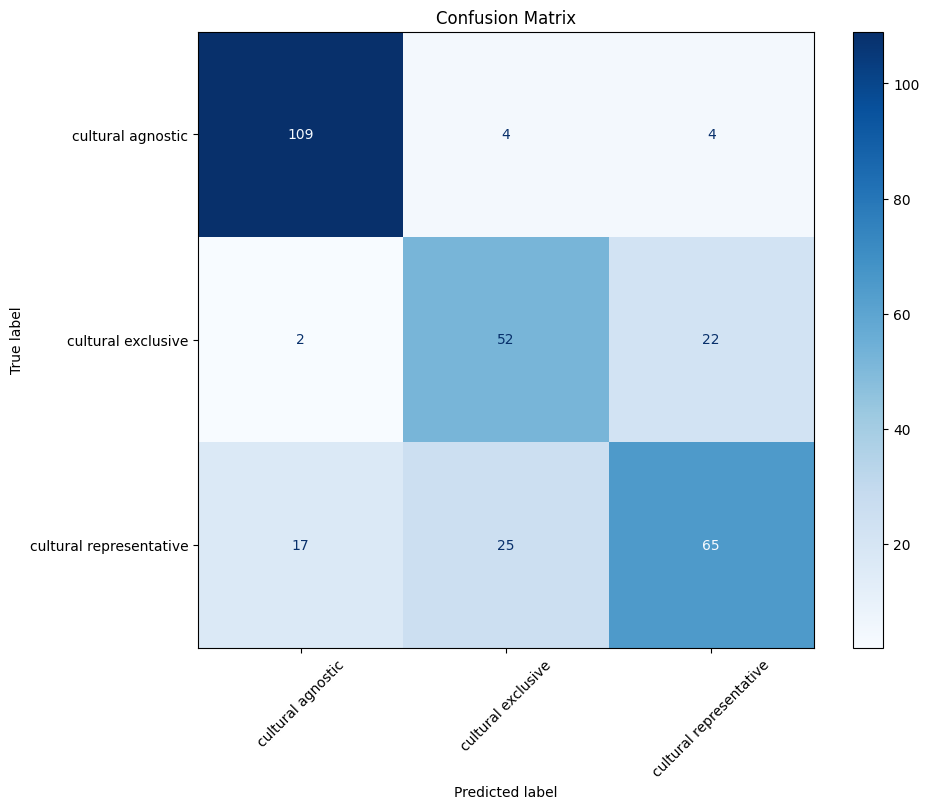

                         precision    recall  f1-score   support

      cultural agnostic       0.85      0.93      0.89       117
     cultural exclusive       0.64      0.68      0.66        76
cultural representative       0.71      0.61      0.66       107

               accuracy                           0.75       300
              macro avg       0.74      0.74      0.74       300
           weighted avg       0.75      0.75      0.75       300



In [ ]:
predict(val_df, "dev_predictions.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # move model to GPU if available
model.to(device)

val_inputs = tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt") # tokenize the validation set
val_inputs = {k: v.to(device) for k, v in val_inputs.items()}

with torch.no_grad(): # disable gradient calculation
    val_outputs = model(**val_inputs)
    val_preds = val_outputs.logits.argmax(dim=1).detach().cpu().numpy() # get the predictions
val_df["classification"] = label_enc.inverse_transform(val_preds) # inverse transform the predictions to get the original labels

plot_confusion_matrix(val_df)
print(classification_report(val_df["label"], val_df["classification"], target_names=label_enc.classes_))